##Import Libraries

In [ ]:
# system packages
import os
import shutil
import sys

# data and numerical management packages
import pandas as pd
import numpy as np

# useful during debugging (progress bars)
from tqdm import tqdm

# typing
from typing import List, Callable, Dict

# TensorFlow
from tensorflow import keras
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import TimeDistributed
from keras.layers import Bidirectional
from keras.layers import Activation
from keras.layers import Embedding
from keras.layers import GRU
import tensorflow as tf

# Scikit-Learn
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import f1_score
from sklearn.metrics import (precision_recall_curve, plot_precision_recall_curve, 
  plot_confusion_matrix, ConfusionMatrixDisplay, PrecisionRecallDisplay)
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# Seaborn
import seaborn as sns

import pickle

import matplotlib.pyplot as plt

Connect to Google Drive and Dataset Download

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!ls /content/drive/MyDrive/NLP/pos-tagging-rnn
!cp "/content/drive/MyDrive/NLP/pos-tagging-rnn/dependency_treebank.zip" "dependency_treebank.zip"
!unzip -qq dependency_treebank.zip

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
dependency_treebank.zip  pos_tagging.ipynb
replace dependency_treebank/wsj_0093.dp? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


Look at the files

In [ ]:
folder = os.path.join(os.getcwd(), "dependency_treebank")
rows = []
file_path = os.path.join(folder, os.listdir(folder)[0])
with open(file_path, mode="r", encoding="utf-8") as text_file:
  text = text_file.read()
  print(text)

-LRB-	-LRB-	11
During	IN	11
its	PRP$	5
centennial	NN	5
year	NN	2
,	,	11
The	NNP	10
Wall	NNP	10
Street	NNP	10
Journal	NNP	11
will	MD	0
report	VB	11
events	NNS	12
of	IN	13
the	DT	17
past	JJ	17
century	NN	14
that	WDT	13
stand	VBP	18
as	IN	19
milestones	NNS	20
of	IN	21
American	JJ	25
business	NN	25
history	NN	22
.	.	11
-RRB-	-RRB-	11

THREE	CD	2
COMPUTERS	NNS	10
THAT	WDT	2
CHANGED	VBD	3
the	DT	6
face	NN	4
of	IN	6
personal	JJ	9
computing	NN	7
were	VBD	0
launched	VBN	10
in	IN	11
1977	CD	12
.	.	10

That	DT	2
year	NN	12
the	DT	5
Apple	NNP	5
II	NNP	11
,	,	11
Commodore	NNP	8
Pet	NNP	11
and	CC	11
Tandy	NNP	11
TRS-80	NNP	12
came	VBD	0
to	TO	12
market	NN	13
.	.	12

The	DT	2
computers	NNS	3
were	VBD	0
crude	JJ	3
by	IN	3
today	NN	7
's	POS	8
standards	NNS	5
.	.	3

Apple	NNP	3
II	NNP	3
owners	NNS	8
,	,	5
for	IN	8
example	NN	5
,	,	5
had	VBD	0
to	TO	10
use	VB	8
their	PRP$	13
television	NN	13
sets	NNS	10
as	IN	10
screens	NNS	14
and	CC	8
stored	VBD	8
data	NNS	17
on	IN	17
audiocassettes	NNS	19
.	.	8

But	CC

Define Utility Functions

In [ ]:
classes_lb = LabelBinarizer()

def plot_history(history):
  plt.plot(history.history["accuracy"])
  plt.plot(history.history["val_accuracy"])
  plt.title("model accuracy")
  plt.ylabel("accuracy")
  plt.xlabel("epoch")
  plt.legend(["train", "validation"], loc="upper left")
  plt.show()

  plt.plot(history.history["loss"])
  plt.plot(history.history["val_loss"])
  plt.title("model loss")
  plt.ylabel("loss")
  plt.xlabel("epoch")
  plt.legend(["train", "validation"], loc="upper left")
  plt.show()

def evaluate_model(model, test_set, punct_classes):
  y_pred = model.predict(test_set[0]["text_index"])[~test_set[0]["class"].isin(punct_classes)]
  y_true = np.argmax(test_set[1], axis = -1).flatten()
  score = f1_score(y_true[~test_set[0]["class"].isin(punct_classes)], np.argmax(y_pred, axis = -1).flatten(), average = "macro")
  
  return (score, y_pred)

##Create the Dataframe

We build a Dataframe with 4 columns (text, class, split and filename). 
`text` is the word to be classified, and `class` refers to the expected POS tag.
The `split` field is used to indicate whether the row is part of training, validation or test set. 
`filename` is the name of the files from which this text comes from.

We build only one Dataframe without splitting the sentences, and we simply append the parts of speech from all sentences and files one after the other.

In [ ]:
folder = os.path.join(os.getcwd(), "dependency_treebank")
rows = []
for index, filename in enumerate(os.listdir(folder)):
  file_path = os.path.join(folder, filename)
  with open(file_path, mode="r", encoding="utf-8") as text_file:
    for line in text_file:
      if line.strip() != "":
        row = line.split()[:2]
        row[0] = row[0].lower()
        row.append("train" if index < 100 else ("validation" if index < 150 else "test"))
        row.append(str(index + 1))
        row_dict = dict(zip(["text", "class", "split", "filename"], row))
        rows.append(row_dict)

df = pd.DataFrame(rows)

print("Dataframe dimensions: ", df.shape)
df.head()

Dataframe dimensions:  (94084, 4)


,text,class,split,filename
0,-lrb-,-LRB-,train,1
1,during,IN,train,1
2,its,PRP$,train,1
3,centennial,NN,train,1
4,year,NN,train,1


## Dataset Analysis

Distribution of the Dataframe values according to all the fields. We observe that the most frequent class is NN, whereas the least frequent one is FW.

In [ ]:
column = 'text'
print("Distribution of texts: ")
print(df[column].value_counts())
print()

column = 'class'
print("Distribution of classes: ")
print(df[column].value_counts())
print()

column = 'split'
print("Distribution of splits: ")
print(df[column].value_counts())
print()

column = 'filename'
print("Distribution of filenames: ")
print(df[column].value_counts())
print()

punct_classes = ["$", "``", "''", ":", "#", ".", ",", "-LRB-", "-RRB-"]
no_punct_classes = df[~df["class"].isin(punct_classes)]["class"].unique()

Distribution of texts: 
,           4885
the         4764
.           3828
of          2325
to          2182
            ... 
plugged        1
jimmy          1
famous         1
blighted       1
ltv            1
Name: text, Length: 10947, dtype: int64

Distribution of classes: 
NN       13166
IN        9857
NNP       9410
DT        8165
NNS       6047
JJ        5834
,         4886
.         3874
CD        3546
VBD       3043
RB        2822
VB        2554
CC        2265
TO        2179
VBN       2134
VBZ       2125
PRP       1716
VBG       1460
VBP       1321
MD         927
POS        824
PRP$       766
$          724
``         712
''         694
:          563
WDT        445
JJR        381
NNPS       244
WP         241
RP         216
JJS        182
WRB        178
RBR        136
-RRB-      126
-LRB-      120
EX          88
RBS         35
PDT         27
#           16
WP$         14
LS          13
FW           4
UH           3
SYM          1
Name: class, dtype: int64

Distribution of spli

Distribution of dataset values grouped by `split` and `class` (and viceversa)

In [ ]:
print("Distribution of classes in split: ")
print(df.groupby(['split','class']).size())

print("Distribution of classes in split: ")
print(df.groupby(['class','split']).size())

Distribution of classes in split: 
split       class
test        #           1
            $         107
            ''        190
            ,        1164
            -LRB-      35
                     ... 
validation  WDT       121
            WP         62
            WP$         6
            WRB        48
            ``        226
Length: 131, dtype: int64
Distribution of classes in split: 
class  split     
#      test            1
       train           3
       validation     12
$      test          107
       train         364
                    ... 
WRB    train          80
       validation     48
``     test          193
       train         293
       validation    226
Length: 131, dtype: int64


Plot of the distribution of classes in both train and test set.

/usr/local/lib/python3.8/dist-packages/numpy/core/fromnumeric.py:3208: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).size
/usr/local/lib/python3.8/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


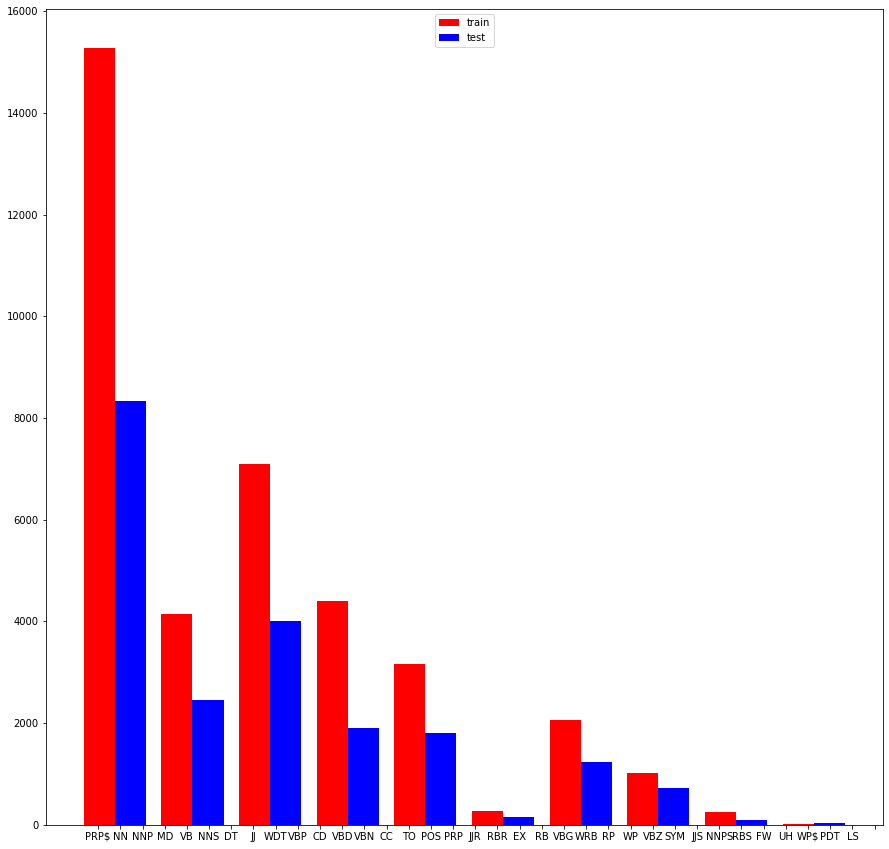

In [ ]:
import numpy
from matplotlib import pyplot
train_data = (df.loc[(df["split"] == "train") & ~df["class"].isin(punct_classes)])["class"].tolist();
test_data = (df.loc[(df["split"] == "test") & ~df["class"].isin(punct_classes)])["class"].tolist();

n_classes = len(df["class"].unique())

plt.figure(figsize = (15, 15))
plt.xticks(range(1, n_classes + 1));
pyplot.hist([train_data, test_data], label=["train", "test"], color=["red", "blue"], align="mid");
pyplot.legend(loc="upper center");
pyplot.show();

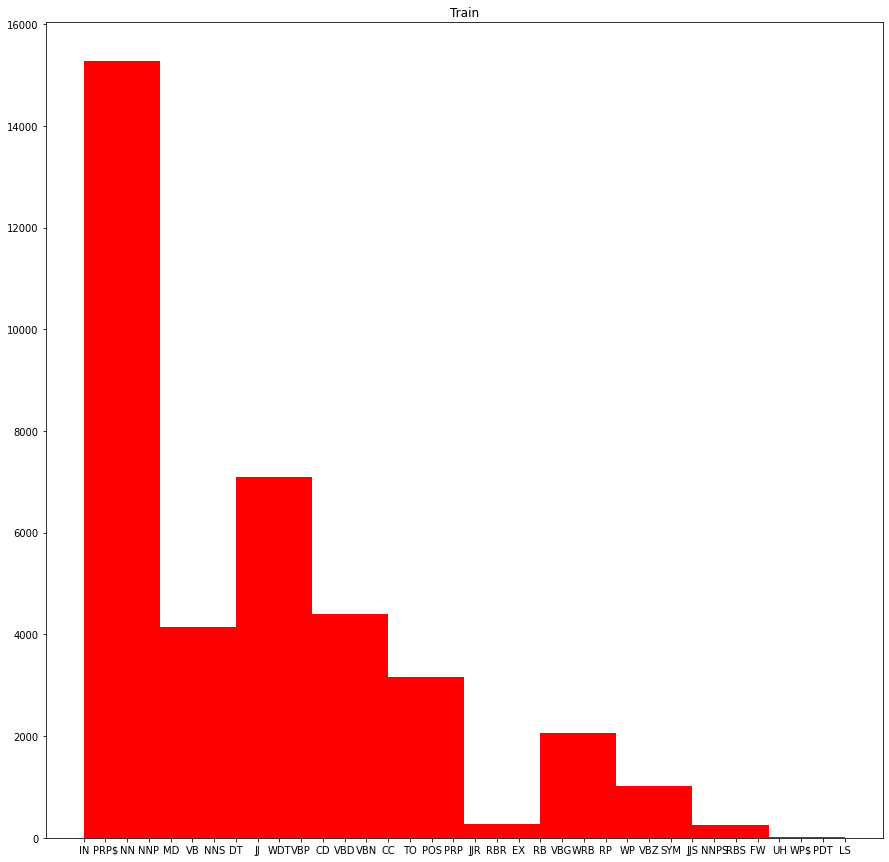

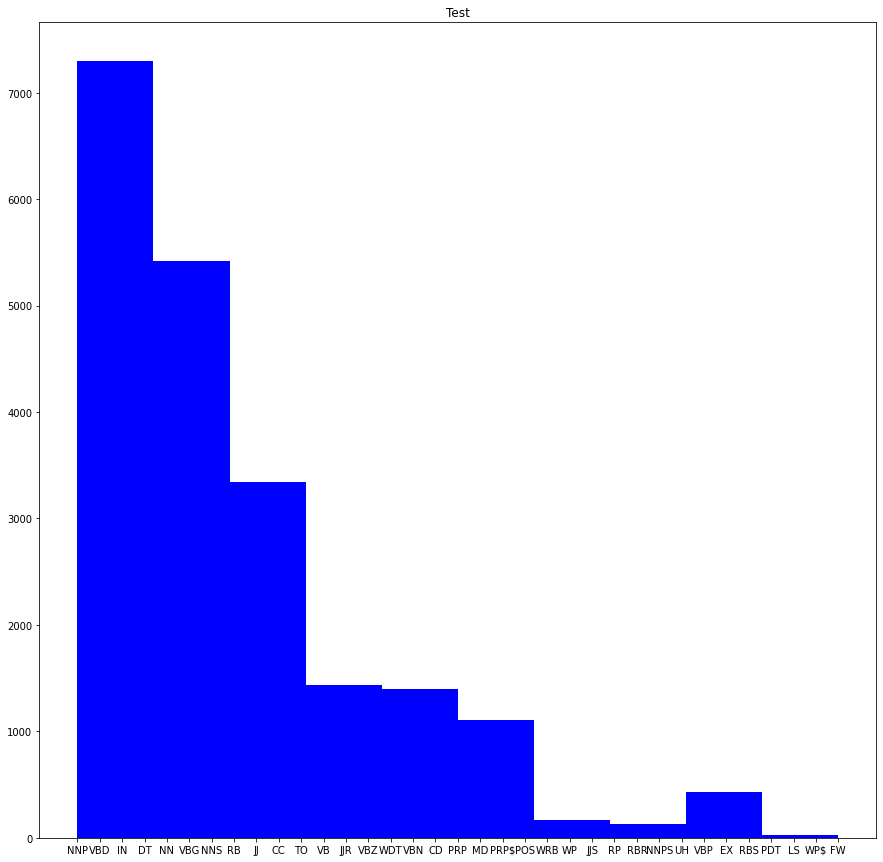

In [ ]:
plot1 = pyplot.figure(1, figsize = (15, 15))
pyplot.hist(train_data, 10, color="red")
pyplot.title("Train")

plot2 = pyplot.figure(2, figsize = (15, 15))
pyplot.hist(test_data, 10, color="blue")
pyplot.title("Test")

pyplot.show()

##Glove-50 Embedding Download

Download the Glove-50 Embedding

In [ ]:
!pip install gensim

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import gensim
import gensim.downloader as gloader

download_path = "glove-wiki-gigaword-50"
emb_model = gloader.load(download_path)

##Create the vocabulary and the embedding matrix

We create three separate vocabularies: respectively one related to train, one to validation and one to test sets, according to the following instructions:

1. Starting vocabulary V1 (GloVe vocabulary)
2. Compute embeddings for terms out of vocabulary V1 (OOV1) of the training split 
3. Add embeddings to the vocabulary, so to obtain vocabulary V2 = V1 + OOV1
4. Compute embeddings for terms OOV2 of the validation split 
5. Add embeddings to the vocabulary, so to obtain vocabulary V3 = V1 + OOV1 + OOV2
6. Compute embeddings for terms OOV3 of the test split 
7. Add embeddings to the vocabulary, so to obtain vocabulary V4 = V1 + OOV1 + OOV2 + OOV3

In [ ]:
vocabulary_glove = emb_model.vocab.keys() # V1

# define the set of words of each dataset split
vocabulary_train = df[df["split"] == "train"]["text"].unique() # V_train
vocabulary_validation = df[df["split"] == "validation"]["text"].unique() # V_validation
vocabulary_test = df[df["split"] == "test"]["text"].unique() # V_test

word_index = dict(zip(vocabulary_glove, range(len(vocabulary_glove)))) # associates each word in the glove vocabulary to an index
embedding_matrix = np.zeros((len(vocabulary_glove), 50)) # initialization of embedding matrix (all zeros)

# update the embedding matrix with the encodings of the vocabulary V1 (glove vocabulary)
for word, i in word_index.items():
  embedding_vector = emb_model.vectors[emb_model.vocab[word].index]
  embedding_matrix[i] = embedding_vector

oov_train = set(vocabulary_train) - set(vocabulary_glove) # OOV1 = V_train - V1
print("Training OOV:", len(oov_train), "(" + str(round((len(oov_train) / len(vocabulary_train)) * 100, 2)) + "%)")

Training OOV: 346 (5.09%)


####OOV Train

The embedding of the OOV words is computed as the weighted average of the embeddings of two previous and two following words in the corpus (for all the occurrences of the OOV word in the dataset).
The nearest words have higher weight. If also the near words are OOV, then we set the embedding to zero.

In [ ]:
train_wi = dict(zip(oov_train, range(len(vocabulary_glove), len(vocabulary_glove) + len(oov_train)))) # associates the words in OOV1 to an index
oov_train_emb_matrix = np.zeros((len(oov_train), 50)) # initialization of embedding matrix of OOV1

# iterate on all OOV1 words
for word, i in train_wi.items():
  emb_sum = np.zeros(50)
  weights = [0.2, 0.3, 0, 0.3, 0.2] # gaussian-like weights
  occurrences = df.index[(df["split"] == "train") & (df["text"] == word)].tolist() # list of all occurrences of the OOV1 word in the train split

  for index in occurrences:
    w_index = 0 # specifies the position of the context word in the window centered on the OOV1 word
    window_sum = np.zeros(50) # weighted sum of the embeddings in the window
    
    #iterate for all the words in the window
    for j in range(index - 2, index + 3):
      if j >= 0 and j < df[df["split"] == "train"].shape[0]: # prevent window out of bounds
        embedding = np.zeros(50) # if the context word is a OOV word, its embedding is set to zero

        # retrive the context word embedding (in glove or OOV1 embadding matrix)
        if df["text"].loc[j] in emb_model.vocab:
          embedding = emb_model.vectors[emb_model.vocab[df["text"].loc[j]].index]
        elif np.sum(oov_train_emb_matrix[train_wi[df["text"][j]] - len(vocabulary_glove)]) != 0:
          embedding = oov_train_emb_matrix[train_wi[df["text"][j]] - len(vocabulary_glove)]
        window_sum += embedding * weights[w_index] # sum for all the context words in the window
        w_index += 1

    emb_sum = emb_sum + window_sum # update the sum for all  the occurrences

  oov_train_emb_matrix[i - len(vocabulary_glove)] = emb_sum / len(occurrences) # average over all the occurrences

In [ ]:
word_index.update(train_wi) # V2 = V1 + OOV1
embedding_matrix = np.concatenate((embedding_matrix, oov_train_emb_matrix)) # embeddings of V2

#### OOV Validation

In [ ]:
oov_validation = set(vocabulary_validation) - set(word_index.keys()) # OOV2
print("Validation OOV:", len(oov_validation), "(" + str(round((len(oov_validation) / len(vocabulary_validation)) * 100, 2)) + "%)")

Validation OOV: 184 (3.55%)


In [ ]:
validation_wi = dict(zip(oov_validation, range(len(word_index), len(word_index) + len(oov_validation)))) # associates the words in OOV2 to an index
oov_validation_emb_matrix = np.zeros((len(oov_validation), 50)) # initialization of embedding matrix of OOV2

# iterate on all OOV2 words
for word, i in validation_wi.items():
  emb_sum = np.zeros(50)
  weights = [0.2, 0.3, 0, 0.3, 0.2] # gaussian-like weights
  occurrences = df.index[(df["split"] == "validation") & (df["text"] == word)].tolist() # list of all occurrences of the OOV2 word in the train split

  for index in occurrences:
    w_index = 0 # specifies the position of the context word in the window centered on the OOV2 word
    window_sum = np.zeros(50) # weighted sum of the embeddings in the window
    
    #iterate for all the words in the window
    for j in range(index - 2, index + 3):
      if j >= 0 and j < df[df["split"] == "validation"].shape[0]: # prevent window out of bounds
        embedding = np.zeros(50) # if the context word is a OOV word, its embedding is set to zero

        # retrive the context word embedding (in glove or OOV2 embadding matrix)
        if df["text"].loc[j] in word_index:
          embedding = embedding_matrix[word_index[df["text"].loc[j]]]
        elif np.sum(oov_validation_emb_matrix[validation_wi[df["text"][j]] - len(word_index)]) != 0:
          embedding = oov_validation_emb_matrix[validation_wi[df["text"][j]] - len(word_index)]
        window_sum += embedding * weights[w_index] # sum for all the context words in the window
        w_index += 1

    emb_sum = emb_sum + window_sum # update the sum for all  the occurrences

  oov_validation_emb_matrix[i - len(word_index)] = emb_sum / len(occurrences) # average over all the occurrences

In [ ]:
word_index.update(validation_wi) # V3 = V2 + OOV2
embedding_matrix = np.concatenate((embedding_matrix, oov_validation_emb_matrix)) # embeddings of V3

#### OOV Test
The embedding of the OOV words for the test splits is computed randomly

In [ ]:
oov_test = set(vocabulary_test) - set(word_index.keys()) # OOV3
print("Test OOV:", len(oov_test), "(" + str(round((len(oov_test) / len(vocabulary_test)) * 100, 2)) + "%)")

Test OOV: 146 (3.17%)


In [ ]:
test_wi = dict(zip(oov_test, range(len(word_index), len(word_index) + len(oov_test)))) # associates the words in OOV3 to an index
oov_test_emb_matrix = np.zeros((len(oov_test), 50)) # initialization of embedding matrix of OOV3

for word, i in test_wi.items():
  if word in emb_model.vocab:
    embedding_vector = emb_model.vectors[emb_model.vocab[word].index]
    oov_test_emb_matrix[i - len(word_index)] = embedding_vector
  else:
    oov_test_emb_matrix[i - len(word_index)] = np.random.rand(50)

In [ ]:
word_index.update(test_wi) # V4 = V3 + OOV3
embedding_matrix = np.concatenate((embedding_matrix, oov_test_emb_matrix)) # embeddings of V4

## Dataset preparation for training

We define another column `text_index` which contains the index of the words in the vocabulary. Then the classes are transformed with one-hot encoding.

In [ ]:
df["text_index"] = df["text"].map(lambda x: word_index[x])

onehot_class = classes_lb.fit_transform(df["class"])
y_train = onehot_class[: df[df["split"] == "train"].shape[0]].reshape(-1, 1, n_classes)
y_validation = onehot_class[df[df["split"] == "train"].shape[0] : df[(df["split"] == "train") | (df["split"] == "validation")].shape[0]].reshape(-1, 1, n_classes)
y_test = onehot_class[df[(df["split"] == "train") | (df["split"] == "validation")].shape[0] :].reshape(-1, 1, n_classes)

In [ ]:
print("Number of samples in the training set:", y_train.shape[0])
print("Number of samples in the validation set:", y_validation.shape[0])
print("Number of samples in the test set:", y_test.shape[0])
print("Total number of samples in the dataset:", onehot_class.shape[0])

print("Check the dimensions:", y_train.shape[0] + y_validation.shape[0] + y_test.shape[0] == onehot_class.shape[0])

42940
27483
23661
94084


True

In [ ]:
vocabulary = list(word_index.keys())

We define four architectures according to the instructions and we analyze the corresponding performances. In all the architectures the first layer is a non-trainable Embedding Layer to load the embeddings (`embedding_matrix`)

##Baseline Model

In [ ]:
model = Sequential()
model.add(Embedding(
    len(vocabulary), 
    50, 
    trainable = False, 
    embeddings_initializer = keras.initializers.Constant(embedding_matrix))
)
model.add(Bidirectional(LSTM(128, return_sequences = True, input_shape=(df[df["split"] == "train"].shape[0], 50))))
model.add(TimeDistributed(Dense(n_classes)))
model.add(Activation("softmax"))
model.compile(loss = "categorical_crossentropy", optimizer = "adam", metrics = ["accuracy"])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 50)          547350    
                                                                 
 bidirectional (Bidirectiona  (None, None, 256)        183296    
 l)                                                              
                                                                 
 time_distributed (TimeDistr  (None, None, 45)         11565     
 ibuted)                                                         
                                                                 
 activation (Activation)     (None, None, 45)          0         
                                                                 
Total params: 742,211
Trainable params: 194,861
Non-trainable params: 547,350
_________________________________________________________________
None


In [ ]:
history = model.fit(
    x = df[df["split"] == "train"]["text_index"], 
    y = y_train, 
    epochs = 15,
    validation_data = (df[df["split"] == "validation"]["text_index"], y_validation),
    batch_size = 16,
    shuffle = False
)

Epoch 1/15
2684/2684 [==============================] - 26s 7ms/step - loss: 1.0327 - accuracy: 0.7157 - val_loss: 0.7429 - val_accuracy: 0.7759
Epoch 2/15
2684/2684 [==============================] - 18s 7ms/step - loss: 0.5690 - accuracy: 0.8319 - val_loss: 0.6033 - val_accuracy: 0.8133
Epoch 3/15
2684/2684 [==============================] - 17s 6ms/step - loss: 0.4565 - accuracy: 0.8623 - val_loss: 0.5409 - val_accuracy: 0.8304
Epoch 4/15
2684/2684 [==============================] - 17s 6ms/step - loss: 0.3933 - accuracy: 0.8806 - val_loss: 0.5035 - val_accuracy: 0.8407
Epoch 5/15
2684/2684 [==============================] - 17s 6ms/step - loss: 0.3507 - accuracy: 0.8924 - val_loss: 0.4789 - val_accuracy: 0.8501
Epoch 6/15
2684/2684 [==============================] - 17s 6ms/step - loss: 0.3193 - accuracy: 0.9008 - val_loss: 0.4619 - val_accuracy: 0.8559
Epoch 7/15
2684/2684 [==============================] - 17s 6ms/step - loss: 0.2950 - accuracy: 0.9073 - val_loss: 0.4500 - val_ac

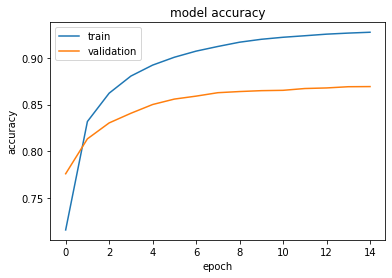

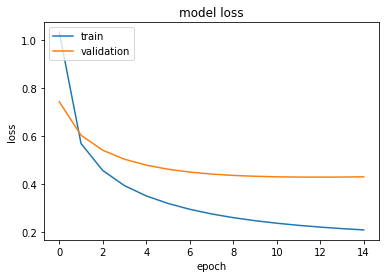

In [ ]:
plot_history(history)

In [ ]:
(f1, preds) = evaluate_model(model, (df[df["split"] == "validation"], y_validation), punct_classes)
print(f1)

859/859 [==============================] - 4s 4ms/step
0.614479871381869


##GRU Model

In [ ]:
model_gru = Sequential()
model_gru.add(Embedding(
    len(vocabulary), 
    50, 
    trainable = False, 
    embeddings_initializer = keras.initializers.Constant(embedding_matrix))
)
model_gru.add(Bidirectional(GRU(128, return_sequences = True, input_shape=(df[df["split"] == "train"].shape[0], 50))))
model_gru.add(TimeDistributed(Dense(n_classes)))
model_gru.add(Activation("softmax"))
model_gru.compile(loss = "categorical_crossentropy", optimizer = "adam", metrics = ["accuracy"])
print(model_gru.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 50)          547350    
                                                                 
 bidirectional_1 (Bidirectio  (None, None, 256)        138240    
 nal)                                                            
                                                                 
 time_distributed_1 (TimeDis  (None, None, 45)         11565     
 tributed)                                                       
                                                                 
 activation_1 (Activation)   (None, None, 45)          0         
                                                                 
Total params: 697,155
Trainable params: 149,805
Non-trainable params: 547,350
_________________________________________________________________
None


In [ ]:
history_gru = model_gru.fit(
    x = df[df["split"] == "train"]["text_index"], 
    y = y_train, 
    epochs = 15,
    validation_data = (df[df["split"] == "validation"]["text_index"], y_validation),
    batch_size = 16,
    shuffle = False
)

Epoch 1/15
2684/2684 [==============================] - 21s 7ms/step - loss: 1.0302 - accuracy: 0.7120 - val_loss: 0.7814 - val_accuracy: 0.7631
Epoch 2/15
2684/2684 [==============================] - 16s 6ms/step - loss: 0.6022 - accuracy: 0.8217 - val_loss: 0.6400 - val_accuracy: 0.8050
Epoch 3/15
2684/2684 [==============================] - 16s 6ms/step - loss: 0.4852 - accuracy: 0.8536 - val_loss: 0.5752 - val_accuracy: 0.8281
Epoch 4/15
2684/2684 [==============================] - 17s 6ms/step - loss: 0.4187 - accuracy: 0.8728 - val_loss: 0.5349 - val_accuracy: 0.8397
Epoch 5/15
2684/2684 [==============================] - 17s 6ms/step - loss: 0.3733 - accuracy: 0.8861 - val_loss: 0.5074 - val_accuracy: 0.8452
Epoch 6/15
2684/2684 [==============================] - 17s 6ms/step - loss: 0.3396 - accuracy: 0.8958 - val_loss: 0.4880 - val_accuracy: 0.8535
Epoch 7/15
2684/2684 [==============================] - 18s 7ms/step - loss: 0.3134 - accuracy: 0.9030 - val_loss: 0.4740 - val_ac

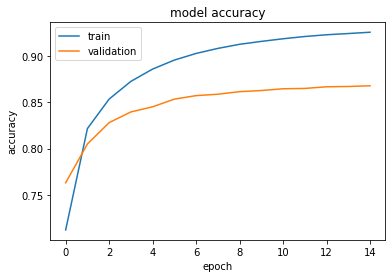

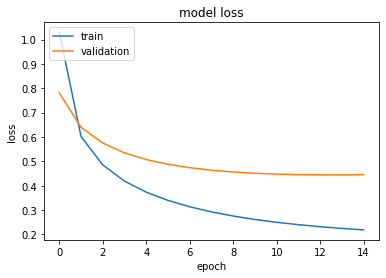

In [ ]:
plot_history(history_gru)

In [ ]:
(f1, preds) = evaluate_model(model_gru, (df[df["split"] == "validation"], y_validation), punct_classes)
print(f1)

859/859 [==============================] - 2s 2ms/step
0.6473878511760612


##Dense Model

In [ ]:
model_dense = Sequential()
model_dense.add(Embedding(
    len(vocabulary), 
    50, 
    trainable = False, 
    embeddings_initializer = keras.initializers.Constant(embedding_matrix))
)
model_dense.add(Bidirectional(LSTM(128, return_sequences = True, input_shape=(df[df["split"] == "train"].shape[0], 50), dropout = 0.2)))
model_dense.add(TimeDistributed(Dense(128)))
model_dense.add(Activation("relu"))
model_dense.add(Dense(n_classes))
model_dense.add(Activation("softmax"))
model_dense.compile(loss = "categorical_crossentropy", optimizer = "adam", metrics = ["accuracy"])
print(model_dense.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, None, 50)          547350    
                                                                 
 bidirectional_2 (Bidirectio  (None, None, 256)        183296    
 nal)                                                            
                                                                 
 time_distributed_2 (TimeDis  (None, None, 128)        32896     
 tributed)                                                       
                                                                 
 activation_2 (Activation)   (None, None, 128)         0         
                                                                 
 dense_3 (Dense)             (None, None, 45)          5805      
                                                                 
 activation_3 (Activation)   (None, None, 45)         

In [ ]:
history_dense = model_dense.fit(
    x = df[df["split"] == "train"]["text_index"], 
    y = y_train, 
    epochs = 15,
    validation_data = (df[df["split"] == "validation"]["text_index"], y_validation),
    batch_size = 32,
    shuffle = False
)

Epoch 1/15
1342/1342 [==============================] - 17s 10ms/step - loss: 1.1664 - accuracy: 0.6713 - val_loss: 0.7737 - val_accuracy: 0.7644
Epoch 2/15
1342/1342 [==============================] - 11s 8ms/step - loss: 0.6803 - accuracy: 0.7918 - val_loss: 0.6318 - val_accuracy: 0.8057
Epoch 3/15
1342/1342 [==============================] - 11s 8ms/step - loss: 0.5747 - accuracy: 0.8229 - val_loss: 0.5727 - val_accuracy: 0.8199
Epoch 4/15
1342/1342 [==============================] - 11s 8ms/step - loss: 0.5174 - accuracy: 0.8379 - val_loss: 0.5305 - val_accuracy: 0.8332
Epoch 5/15
1342/1342 [==============================] - 11s 8ms/step - loss: 0.4735 - accuracy: 0.8488 - val_loss: 0.5048 - val_accuracy: 0.8377
Epoch 6/15
1342/1342 [==============================] - 11s 8ms/step - loss: 0.4471 - accuracy: 0.8585 - val_loss: 0.4810 - val_accuracy: 0.8481
Epoch 7/15
1342/1342 [==============================] - 11s 8ms/step - loss: 0.4202 - accuracy: 0.8646 - val_loss: 0.4679 - val_a

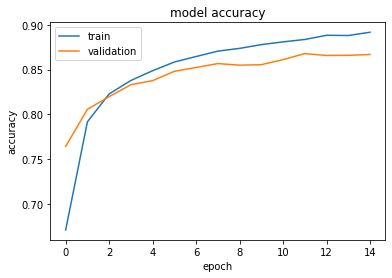

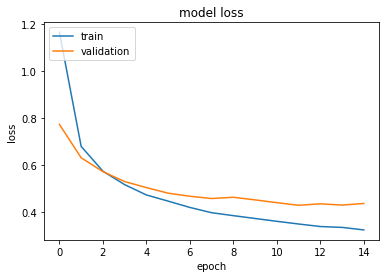

In [ ]:
plot_history(history_dense)

In [ ]:
(f1, preds) = evaluate_model(model_dense, (df[df["split"] == "validation"], y_validation), punct_classes)
print(f1)

859/859 [==============================] - 3s 3ms/step
0.5978346006481895


##2 LSTM Model

In [ ]:
model_lstm = Sequential()
model_lstm.add(Embedding(
    len(vocabulary), 
    50, 
    trainable = False, 
    embeddings_initializer = keras.initializers.Constant(embedding_matrix))
)
model_lstm.add(Bidirectional(LSTM(128, return_sequences = True, input_shape=(df[df["split"] == "train"].shape[0], 50))))
model_lstm.add(LSTM(256, return_sequences = True, dropout = 0.2))
model_lstm.add(TimeDistributed(Dense(n_classes)))
model_lstm.add(Activation("softmax"))
model_lstm.compile(loss = "categorical_crossentropy", optimizer = "adam", metrics = ["accuracy"])
print(model_lstm.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, None, 50)          547350    
                                                                 
 bidirectional_3 (Bidirectio  (None, None, 256)        183296    
 nal)                                                            
                                                                 
 lstm_3 (LSTM)               (None, None, 256)         525312    
                                                                 
 time_distributed_3 (TimeDis  (None, None, 45)         11565     
 tributed)                                                       
                                                                 
 activation_4 (Activation)   (None, None, 45)          0         
                                                                 
Total params: 1,267,523
Trainable params: 720,173
Non-

In [ ]:
history_lstm = model_lstm.fit(
    x = df[df["split"] == "train"]["text_index"], 
    y = y_train, 
    epochs = 15,
    validation_data = (df[df["split"] == "validation"]["text_index"], y_validation),
    batch_size = 32,
    shuffle = False
)

Epoch 1/15
1342/1342 [==============================] - 20s 12ms/step - loss: 1.0916 - accuracy: 0.6916 - val_loss: 0.7395 - val_accuracy: 0.7641
Epoch 2/15
1342/1342 [==============================] - 14s 11ms/step - loss: 0.5715 - accuracy: 0.8279 - val_loss: 0.5878 - val_accuracy: 0.8133
Epoch 3/15
1342/1342 [==============================] - 12s 9ms/step - loss: 0.4577 - accuracy: 0.8589 - val_loss: 0.5125 - val_accuracy: 0.8373
Epoch 4/15
1342/1342 [==============================] - 12s 9ms/step - loss: 0.3925 - accuracy: 0.8759 - val_loss: 0.4684 - val_accuracy: 0.8507
Epoch 5/15
1342/1342 [==============================] - 12s 9ms/step - loss: 0.3473 - accuracy: 0.8879 - val_loss: 0.4411 - val_accuracy: 0.8585
Epoch 6/15
1342/1342 [==============================] - 12s 9ms/step - loss: 0.3150 - accuracy: 0.8981 - val_loss: 0.4283 - val_accuracy: 0.8628
Epoch 7/15
1342/1342 [==============================] - 12s 9ms/step - loss: 0.2896 - accuracy: 0.9037 - val_loss: 0.4143 - val_

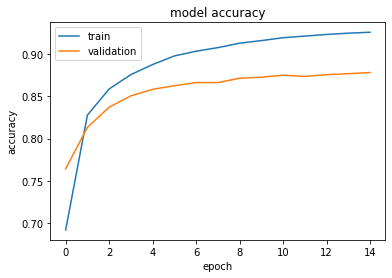

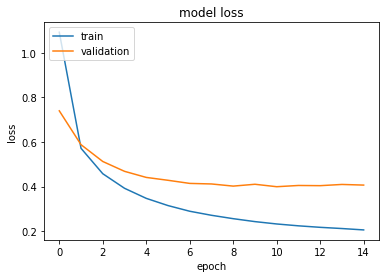

In [ ]:
plot_history(history_lstm)

In [ ]:
(f1, preds) = evaluate_model(model_lstm, (df[df["split"] == "validation"], y_validation), punct_classes)
print(f1)

859/859 [==============================] - 4s 3ms/step
0.6527894669822754


##Best Models

###1 - 2LSTM Model

In [ ]:
df_test = df[df["split"] == "test"]
(f1_lstm, preds_lstm) = evaluate_model(model_lstm, (df[df["split"] == "test"], y_test), punct_classes)
preds_label_lstm = classes_lb.inverse_transform(preds_lstm.reshape(-1, 45))
y_true_lstm = classes_lb.inverse_transform(y_test.reshape(-1, n_classes))[~df_test["class"].isin(punct_classes)]

740/740 [==============================] - 2s 3ms/step


###2 - Dense Model

In [ ]:
df_test = df[df["split"] == "test"]
(f1_dense, preds_dense) = evaluate_model(model_dense, (df[df["split"] == "test"], y_test), punct_classes)
preds_label_dense = classes_lb.inverse_transform(preds_dense.reshape(-1, 45))
y_true_dense = classes_lb.inverse_transform(y_test.reshape(-1, n_classes))[~df_test["class"].isin(punct_classes)]

740/740 [==============================] - 2s 3ms/step


##Error Analysis

We perform an error analysis on the two best models in order to understand which are the most meaningful errors

###1 - 2LSTM Model

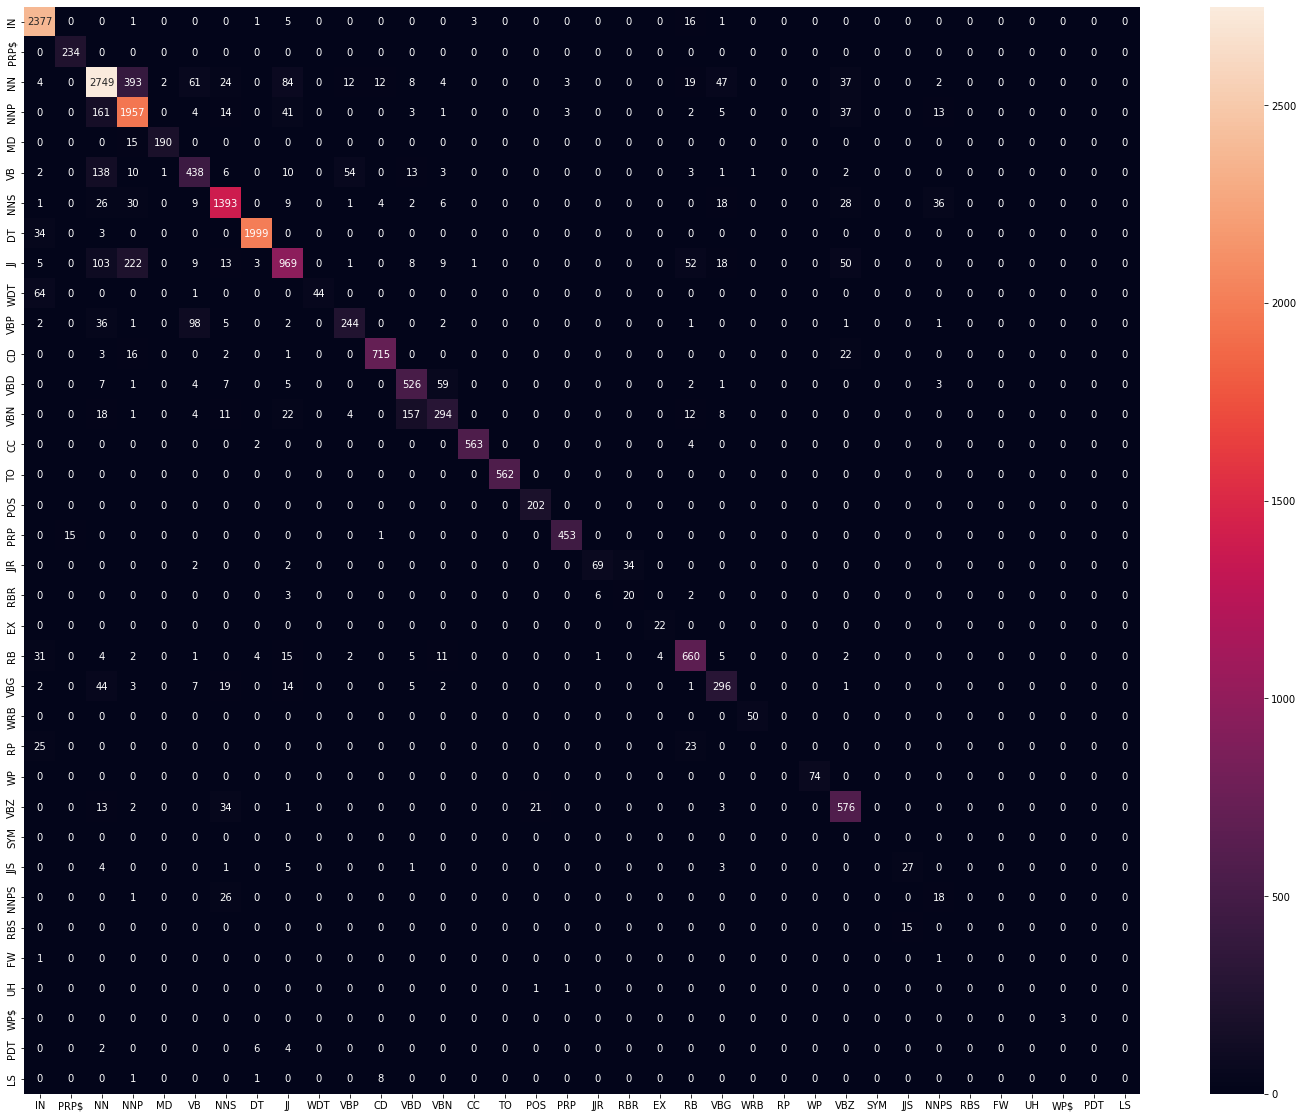

In [ ]:
plt.subplots(figsize = (25, 20))
cf_matrix = confusion_matrix(y_true_lstm, preds_label_lstm, labels = no_punct_classes)
sns.heatmap(cf_matrix, annot=True, fmt="g", xticklabels = no_punct_classes, yticklabels = no_punct_classes)

For each class, we print the two classes with which it is mostly confused

In [ ]:
for index, row in enumerate(cf_matrix):
  tmp = np.copy(row)
  tmp[index] = 0
  print("Class ", no_punct_classes[index])
  max_confused = np.argpartition(tmp, -2)[-2:]
  print("Most confused with: ", end = "")
  for m in max_confused:
    print(no_punct_classes[m], "(" + str(tmp[m]) + ")", end = ", ")
  print("\n")

Class  IN
Most confused with: JJ (5), RB (16), 

Class  PRP$
Most confused with: VBP (0), LS (0), 

Class  NN
Most confused with: JJ (84), NNP (393), 

Class  NNP
Most confused with: JJ (41), NN (161), 

Class  MD
Most confused with: VBD (0), NNP (15), 

Class  VB
Most confused with: VBP (54), NN (138), 

Class  NNS
Most confused with: NNP (30), NNPS (36), 

Class  DT
Most confused with: NN (3), IN (34), 

Class  JJ
Most confused with: NN (103), NNP (222), 

Class  WDT
Most confused with: VB (1), IN (64), 

Class  VBP
Most confused with: NN (36), VB (98), 

Class  CD
Most confused with: NNP (16), VBZ (22), 

Class  VBD
Most confused with: NN (7), VBN (59), 

Class  VBN
Most confused with: JJ (22), VBD (157), 

Class  CC
Most confused with: DT (2), RB (4), 

Class  TO
Most confused with: VBP (0), LS (0), 

Class  POS
Most confused with: VBP (0), LS (0), 

Class  PRP
Most confused with: CD (1), PRP$ (15), 

Class  JJR
Most confused with: JJ (2), RBR (34), 

Class  RBR
Most confused with:

In [ ]:
print(classification_report(y_true_lstm, preds_label_lstm));

              precision    recall  f1-score   support

          CC       0.99      0.99      0.99       569
          CD       0.97      0.94      0.95       759
          DT       0.99      0.98      0.99      2036
          EX       0.85      1.00      0.92        22
          FW       0.00      0.00      0.00         2
          IN       0.93      0.99      0.96      2404
          JJ       0.81      0.66      0.73      1463
         JJR       0.91      0.64      0.75       107
         JJS       0.64      0.66      0.65        41
          LS       0.00      0.00      0.00        10
          MD       0.98      0.93      0.95       205
          NN       0.83      0.79      0.81      3461
         NNP       0.74      0.87      0.80      2241
        NNPS       0.24      0.40      0.30        45
         NNS       0.90      0.89      0.89      1563
         PDT       0.00      0.00      0.00        12
         POS       0.90      1.00      0.95       202
         PRP       0.98    

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Example of a prediction over a sentence in the test set

In [ ]:
print("\tWORD\t\t\tACTUAL\t\t\tPREDICTED")
index = 0

for _, row in df_test.iterrows():
  pred = "PUNCT" if row["class"] in punct_classes else preds_label_lstm[index]
  tab = (3 if len(row["text"]) < 8 else 2) * "\t"    
  print(("OK" if row["class"] == preds_label_lstm[index] else "-") + "\t" + row["text"] + tab + row["class"] + "\t\t\t" + pred)
  if not row["class"] in punct_classes:
    index += 1
  if row.loc["text"] == ".":
    break;

	WORD			ACTUAL			PREDICTED
OK	new			NNP			NNP
OK	england			NNP			NNP
OK	electric		NNP			NNP
OK	system			NNP			NNP
OK	bowed			VBD			VBD
OK	out			IN			IN
OK	of			IN			IN
OK	the			DT			DT
OK	bidding			NN			NN
OK	for			IN			IN
-	public			NNP			JJ
OK	service			NNP			NNP
OK	co.			NNP			NNP
OK	of			IN			IN
OK	new			NNP			NNP
OK	hampshire		NNP			NNP
-	,			,			PUNCT
OK	saying			VBG			VBG
OK	that			IN			IN
OK	the			DT			DT
-	risks			NNS			NN
OK	were			VBD			VBD
OK	too			RB			RB
-	high			JJ			NNP
OK	and			CC			CC
OK	the			DT			DT
-	potential		JJ			NN
OK	payoff			NN			NN
OK	too			RB			RB
OK	far			RB			RB
OK	in			IN			IN
OK	the			DT			DT
-	future			NN			JJ
OK	to			TO			TO
-	justify			VB			NN
OK	a			DT			DT
OK	higher			JJR			JJR
OK	offer			NN			NN
-	.			.			PUNCT


Compute the metric on the test set on the 2LSTM model

In [ ]:
print("F1 score:", f1_lstm)

F1 score: 0.6805383065507346


###2 - Dense Model

We repeat the same analysis for the second best model

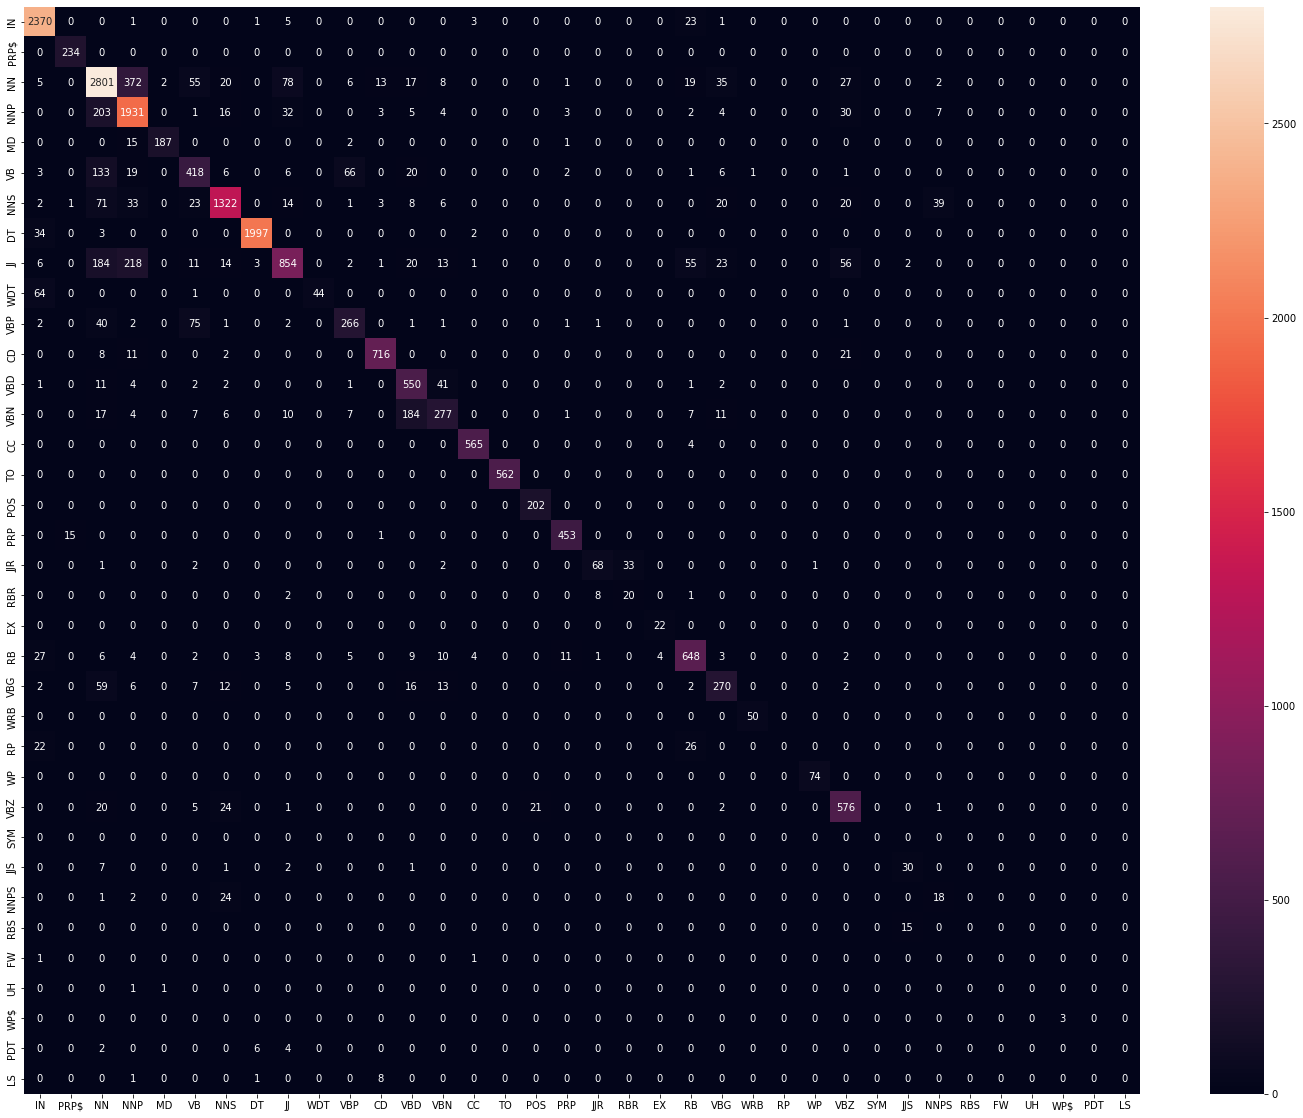

In [ ]:
plt.subplots(figsize = (25, 20))
cf_matrix = confusion_matrix(y_true_dense, preds_label_dense, labels = no_punct_classes)
sns.heatmap(cf_matrix, annot=True, fmt="g", xticklabels = no_punct_classes, yticklabels = no_punct_classes)

For each class, we print the two classes with which it is mostly confused

In [ ]:
for index, row in enumerate(cf_matrix):
  tmp = np.copy(row)
  tmp[index] = 0
  print("Class ", no_punct_classes[index])
  max_confused = np.argpartition(tmp, -2)[-2:]
  print("Most confused with: ", end = "")
  for m in max_confused:
    print(no_punct_classes[m], "(" + str(tmp[m]) + ")", end = ", ")
  print("\n")

Class  IN
Most confused with: JJ (5), RB (23), 

Class  PRP$
Most confused with: VBP (0), LS (0), 

Class  NN
Most confused with: JJ (78), NNP (372), 

Class  NNP
Most confused with: JJ (32), NN (203), 

Class  MD
Most confused with: VBP (2), NNP (15), 

Class  VB
Most confused with: VBP (66), NN (133), 

Class  NNS
Most confused with: NNPS (39), NN (71), 

Class  DT
Most confused with: NN (3), IN (34), 

Class  JJ
Most confused with: NN (184), NNP (218), 

Class  WDT
Most confused with: VB (1), IN (64), 

Class  VBP
Most confused with: NN (40), VB (75), 

Class  CD
Most confused with: NNP (11), VBZ (21), 

Class  VBD
Most confused with: NN (11), VBN (41), 

Class  VBN
Most confused with: NN (17), VBD (184), 

Class  CC
Most confused with: VBD (0), RB (4), 

Class  TO
Most confused with: VBP (0), LS (0), 

Class  POS
Most confused with: VBP (0), LS (0), 

Class  PRP
Most confused with: CD (1), PRP$ (15), 

Class  JJR
Most confused with: VB (2), RBR (33), 

Class  RBR
Most confused with

In [ ]:
print(classification_report(y_true_dense, preds_label_dense));

              precision    recall  f1-score   support

       -RRB-       0.00      0.00      0.00         0
          CC       0.98      0.99      0.99       569
          CD       0.96      0.94      0.95       759
          DT       0.99      0.98      0.99      2036
          EX       0.85      1.00      0.92        22
          FW       0.00      0.00      0.00         2
          IN       0.93      0.99      0.96      2404
          JJ       0.83      0.58      0.69      1463
         JJR       0.87      0.64      0.74       107
         JJS       0.64      0.73      0.68        41
          LS       0.00      0.00      0.00        10
          MD       0.98      0.91      0.95       205
          NN       0.79      0.81      0.80      3461
         NNP       0.74      0.86      0.79      2241
        NNPS       0.27      0.40      0.32        45
         NNS       0.91      0.85      0.88      1563
         PDT       0.00      0.00      0.00        12
         POS       0.91    

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1

Example of a prediction over a sentence in the test set

In [ ]:
print("\tWORD\t\t\tACTUAL\t\t\tPREDICTED")
index = 0

for _, row in df_test.iterrows():
  pred = "PUNCT" if row["class"] in punct_classes else preds_label_dense[index]
  tab = (3 if len(row["text"]) < 8 else 2) * "\t"    
  print(("OK" if row["class"] == preds_label_dense[index] else "-") + "\t" + row["text"] + tab + row["class"] + "\t\t\t" + pred)
  if not row["class"] in punct_classes:
    index += 1
  if row.loc["text"] == ".":
    break;

	WORD			ACTUAL			PREDICTED
OK	new			NNP			NNP
OK	england			NNP			NNP
OK	electric		NNP			NNP
-	system			NNP			NN
OK	bowed			VBD			VBD
OK	out			IN			IN
OK	of			IN			IN
OK	the			DT			DT
OK	bidding			NN			NN
OK	for			IN			IN
-	public			NNP			JJ
OK	service			NNP			NNP
OK	co.			NNP			NNP
OK	of			IN			IN
OK	new			NNP			NNP
OK	hampshire		NNP			NNP
-	,			,			PUNCT
OK	saying			VBG			VBG
OK	that			IN			IN
OK	the			DT			DT
OK	risks			NNS			NNS
OK	were			VBD			VBD
OK	too			RB			RB
-	high			JJ			NNP
OK	and			CC			CC
OK	the			DT			DT
OK	potential		JJ			JJ
OK	payoff			NN			NN
OK	too			RB			RB
OK	far			RB			RB
OK	in			IN			IN
OK	the			DT			DT
-	future			NN			JJ
OK	to			TO			TO
-	justify			VB			VBG
OK	a			DT			DT
OK	higher			JJR			JJR
OK	offer			NN			NN
-	.			.			PUNCT


Compute the metric on the test set on the 2LSTM model

In [ ]:
print("F1 score:", f1_dense)

F1 score: 0.6572682725838107
